In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.math import argmax
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os
from gym import spaces

In [2]:
# Networks
def get_actor(num_states, num_actions, continuous, disc_actions_num, layer1, layer2,
              init_weights_min=-0.003, init_weights_max=0.003):
    
    last_init = tf.random_uniform_initializer(minval=init_weights_min, maxval=init_weights_max)
    
    ### ACTOR NETWORK ###
    
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.LayerNormalization(axis=1)(out)
    out = layers.Dense(layer2, activation="relu")(out)
    out = layers.LayerNormalization(axis=1)(out)
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(disc_actions_num, activation="softmax", kernel_initializer=last_init)(out)
    
    return tf.keras.Model(inputs, outputs)

def get_critic(num_states, num_actions, continuous, disc_actions_num, layer1, layer2):
    
    ### CRITIC NETWORK ###
    
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(64, activation="relu")(state_input)
    
    if continuous:
        action_input = layers.Input(shape=(num_actions,))
    else:
        action_input = layers.Input(shape=(disc_actions_num,))
    action_out = layers.Dense(64, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.LayerNormalization(axis=1)(out)
    out = layers.Dense(layer2, activation="relu")(out)
    out = layers.LayerNormalization(axis=1)(out)
    outputs = layers.Dense(num_actions)(out)

    return tf.keras.Model([state_input, action_input], outputs)

In [3]:
# Helpers
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta, dt, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))
        
def fixed(x, episode):
    return x

In [4]:
class Agent:
    def __init__(self, num_states, num_actions, continuous,
            buffer_capacity, batch_size, std_dev, actor_lr, critic_lr,
            gamma, tau, epsilon, adam_critic_eps, adam_actor_eps, 
            actor_amsgrad, critic_amsgrad, actor_layer_1, actor_layer_2, 
            critic_layer_1, critic_layer_2, theta, dt, disc_actions_num, loss_func):
        
        self.continuous = continuous
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        if self.continuous:
            self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        else:
            self.action_buffer = np.zeros((self.buffer_capacity, disc_actions_num))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon # Epsilon greedy
        self.loss_func = loss_func
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), theta=theta, dt=dt)
        
        self.actor_model = get_actor(num_states, num_actions, continuous, disc_actions_num, actor_layer_1, actor_layer_2)
        self.critic_model = get_critic(num_states, num_actions, continuous, disc_actions_num, critic_layer_1, critic_layer_2)
        self.target_actor = get_actor(num_states, num_actions, continuous, disc_actions_num, actor_layer_1, actor_layer_2)
        self.target_critic = get_critic(num_states, num_actions, continuous, disc_actions_num, critic_layer_1, critic_layer_2)
        
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_actor_eps, amsgrad=actor_amsgrad,
        )
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_critic_eps, amsgrad=critic_amsgrad,
        )
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
    
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Calculation of loss and gradients
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, loss_func):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + done_batch * self.gamma * self.target_critic([next_state_batch, target_actions], training=True)
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = loss_func(y, critic_value)

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)

        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch, self.loss_func)
        
    def policy(self, state, disc_actions_num=4, noise_object=0, use_noise=True, noise_mult=1, rng=np.random.default_rng(1)):
        if use_noise:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                
                noise = noise_object()
                
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, -1, 1)
                return [np.squeeze(legal_action)][0]
            else:
                if (rng.random() < self.epsilon):
                    action = np.zeros(disc_actions_num)
                    action[np.random.randint(0, disc_actions_num, 1)[0]] = 1
                    return action
                else:
                    return self.actor_model(state)
        else:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, -1, 1)
                return [np.squeeze(legal_action)][0]
            else:
                return self.actor_model(state)

In [5]:
def run(env, total_trials=1, total_episodes=100, buffer_capacity=50000, batch_size=64, 
            std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, reward_mod=False, solved=200,
            continuous=True, seed=1453, start_steps=0,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07,
            actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, actor_layer_2=256,
            critic_layer_1=256, critic_layer_2=256, theta=0.15, dt=1e-2, disc_actions_num=4,
            loss_func=losses.MeanAbsoluteError(), use_gpu=True):
    
    tot_time = time.time()
    
    _ = env.reset(seed=seed)
    rng = np.random.default_rng(seed)
    
    try:
        continuous = env.continuous
    except:
        continuous = True
    
    if not use_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
        
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    env.action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')
    
    ep_reward_list = []
    avg_reward_list = []
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states, num_actions, continuous,
            buffer_capacity, batch_size, std_dev, actor_lr, critic_lr,
            gamma, tau, epsilon, adam_critic_eps, adam_actor_eps, 
            actor_amsgrad, critic_amsgrad, actor_layer_1, actor_layer_2, 
            critic_layer_1, critic_layer_2, theta, dt, disc_actions_num, loss_func)

        for ep in range(total_episodes):
            before = time.time()
            
            agent.gamma = gamma_func(agent.gamma, ep)
            agent.tau = tau_func(agent.tau, ep)
            agent.critic_lr = critic_lr_func(agent.critic_lr, ep)
            agent.actor_lr = actor_lr_func(agent.actor_lr, ep)
            agent.std_dev = std_dev_func(agent.std_dev, ep)
            agent.epsilon = epsilon_func(agent.epsilon, ep)
            noise_mult = noise_mult_func(noise_mult, ep)

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, disc_actions_num=disc_actions_num, noise_object=agent.ou_noise, noise_mult=noise_mult, rng=rng)
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                if continuous:
                    try:
                        len(action)
                    except:
                        action = [action]
                    state, reward, done, info = env.step(action)
                else:
                    state, reward, done, info = env.step(np.argmax(action))
                
                true_reward += reward
                
                # Reward modification
                if reward_mod:
                    reward -= abs(state[0])

                terminal_state = int(not done)
                
                agent.record((prev_state, action, reward, state, terminal_state))

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                episodic_reward += reward
                
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_reward_list[trial].append(true_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}".format(env.spec.id, continuous, timestamp)
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + 'actor-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + 'critic-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    try:
        plt.savefig('Graphs/' + save_name + '.png')
    except:
        print('fig save fail')
    plt.show()
    
    print('total time:', time.time() - tot_time, 's')
    
    if return_rewards:
        return true_reward_list

In [6]:
def test(env, actor_weights, total_episodes=10, render=False, disc_actions_num=4, seed=1453):
    rewards = []
    
    _ = env.reset(seed=seed)
    
    try:
        continuous = env.continuous
    except:
        continuous = True
        
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    env.action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, continuous=continuous, 
                buffer_capacity=0, batch_size=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
            action = agent.policy(state=tf_prev_state, disc_actions_num=disc_actions_num, use_noise=False)

            if continuous:
                try:
                    len(action)
                except:
                    action = [action]
                state, reward, done, info = env.step(action)
            else:
                state, reward, done, info = env.step(np.argmax(action))
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [7]:
def random(env, total_episodes=10, render=False, seed=1453):
    
    _ = env.reset(seed=seed)
    rng = np.random.default_rng(seed)
    
    try:
        continuous = env.continuous
    except:
        continuous = True
        
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    env.action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [8]:
env = gym.make("Pendulum-v1")

C:\Users\Ferdinand\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [12]:
env.spec

EnvSpec(id='Pendulum-v1', entry_point='gym.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, kwargs={}, namespace=None, name='Pendulum', version=1)

Ep 0 * AvgReward -1684.61 * true AvgReward -1684.61 * Reward -1684.61 * True Reward -1684.61 * time 9.53 * step 200
Ep 1 * AvgReward -1657.45 * true AvgReward -1657.45 * Reward -1630.28 * True Reward -1630.28 * time 6.69 * step 400
Ep 2 * AvgReward -1684.77 * true AvgReward -1684.77 * Reward -1739.42 * True Reward -1739.42 * time 6.69 * step 600
Ep 3 * AvgReward -1666.54 * true AvgReward -1666.54 * Reward -1611.83 * True Reward -1611.83 * time 6.71 * step 800
Ep 4 * AvgReward -1562.86 * true AvgReward -1562.86 * Reward -1148.15 * True Reward -1148.15 * time 6.70 * step 1000
actor save fail
critic save fail
fig save fail


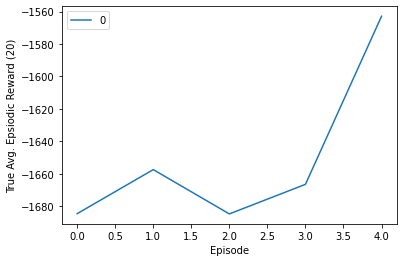

total time: 37.27134895324707 s


In [11]:
run(env=env, total_episodes=5, render=True, disc_actions_num=4)